---
## Goals of the project:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



Number of images where corners are found: 17
Number of images where corners are NOT found: 3


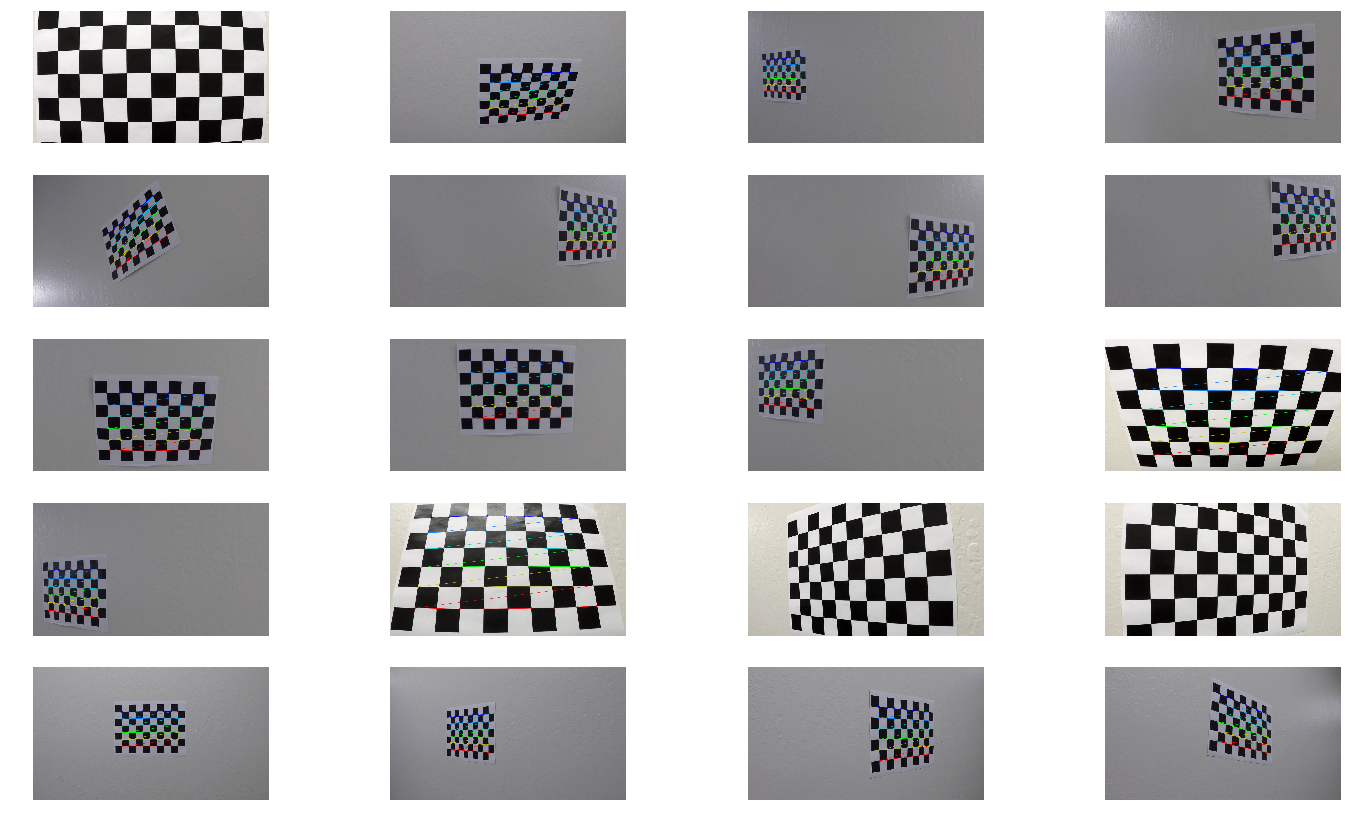

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpmg
import glob
import pickle
%matplotlib inline

#Read the list of images to calibrate
images = glob.glob('./camera_cal/calibration*.jpg')
#print(len(images))

#Arrays to store object points and image points for all the images
object_points = []
image_points = []

#Placeholders for object points
object_points_placeholder = np.zeros((6*9,3), np.float32)
object_points_placeholder[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

plt.figure(figsize=(20, 25))

plt_index = 0
true_count = 0
false_count = 0
for filename in images:
    plt.subplot(11, 4, plt_index+1)
    #print(filename)
    image = mpmg.imread(filename)
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    
    #Convert image to grayscale
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    #Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_image,(9,6),None)
    
    #If object corners are found in the chessboard add Object points to Image points
     
    if ret == True:
        image_points.append(corners)
        object_points.append(object_points_placeholder)
        
        #Draw and display the corners
        image = cv2.drawChessboardCorners(image,(9,6),corners,ret)
        plt.imshow(image)
        true_count += 1
    else:
        #print('Return is False')
        false_count += 1
    plt_index += 1

print("Number of images where corners are found:", true_count )
print("Number of images where corners are NOT found:", false_count )

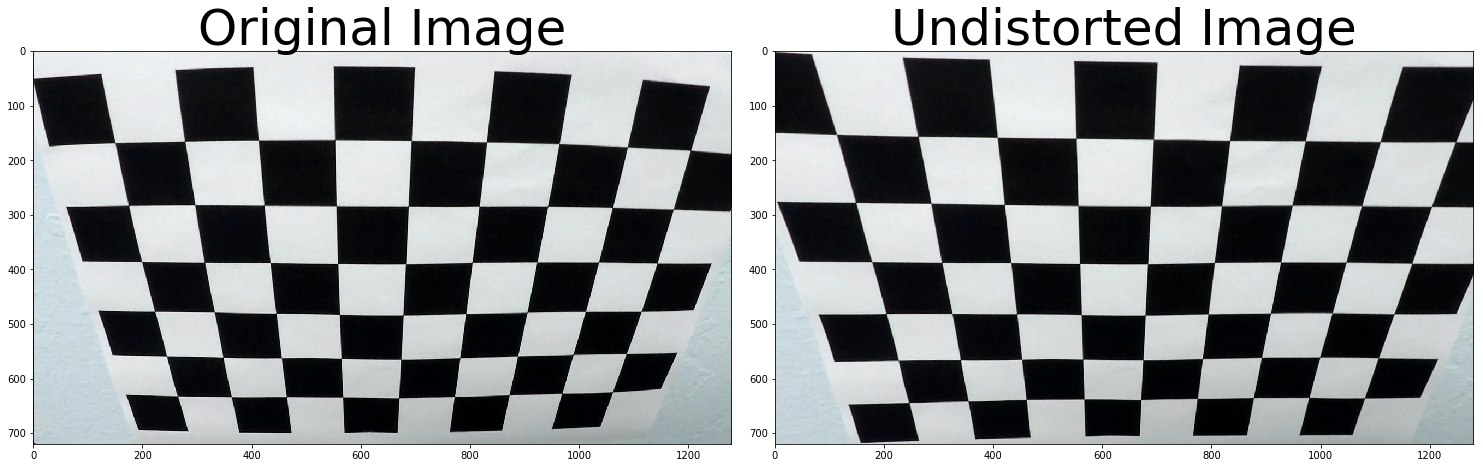

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpmg
import os


image = cv2.imread('./camera_cal/calibration2.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points,image.shape[0:2], None, None)
destination_image = cv2.undistort(image, mtx, dist, None, mtx)

#Pickle the camera calibration results
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(destination_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



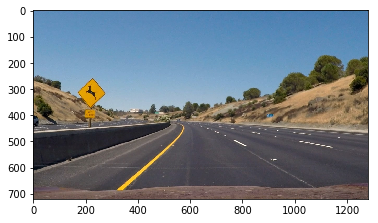

In [4]:

test_image = cv2.imread('./test_images/test2.jpg')
#plt.imshow(image)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
#test_image_BGR2RGB = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)

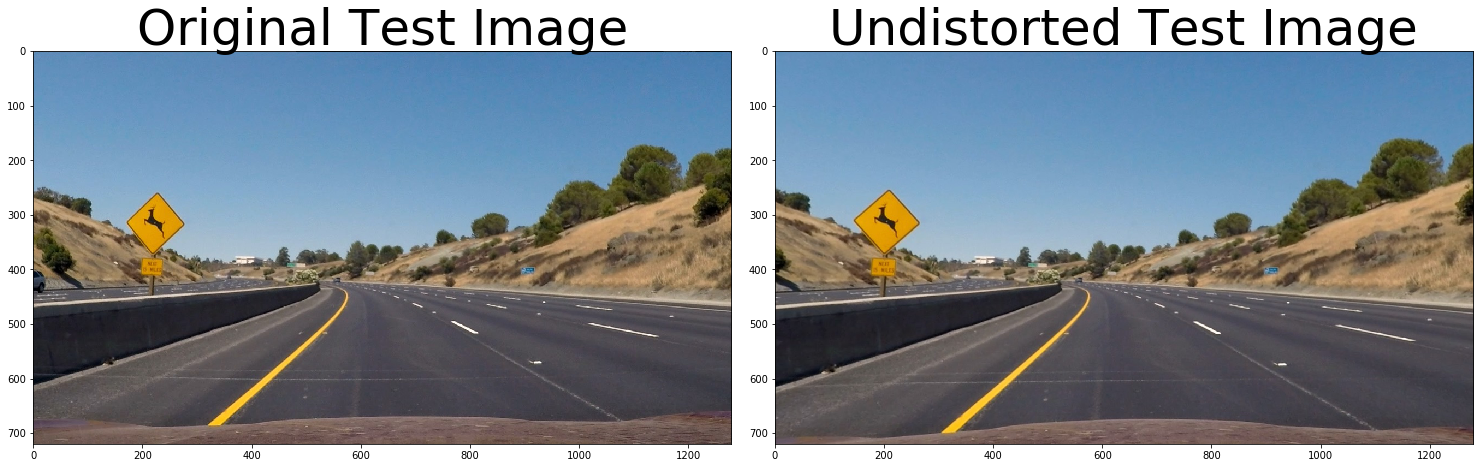

In [5]:

test_destination_image = cv2.undistort(test_image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Test Image', fontsize=50)
ax2.imshow(test_destination_image)
ax2.set_title('Undistorted Test Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

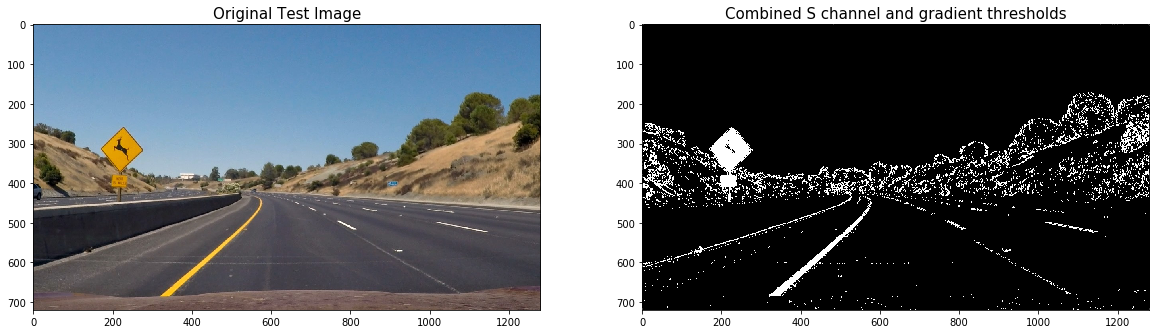

In [6]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
img = cv2.imread('./test_images/test2.jpg')
img_BGR2RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Test Image', fontsize=15)
ax1.imshow(img_BGR2RGB)

ax2.set_title('Combined S channel and gradient thresholds', fontsize=15)
ax2.imshow(combined_binary, cmap='gray')

True

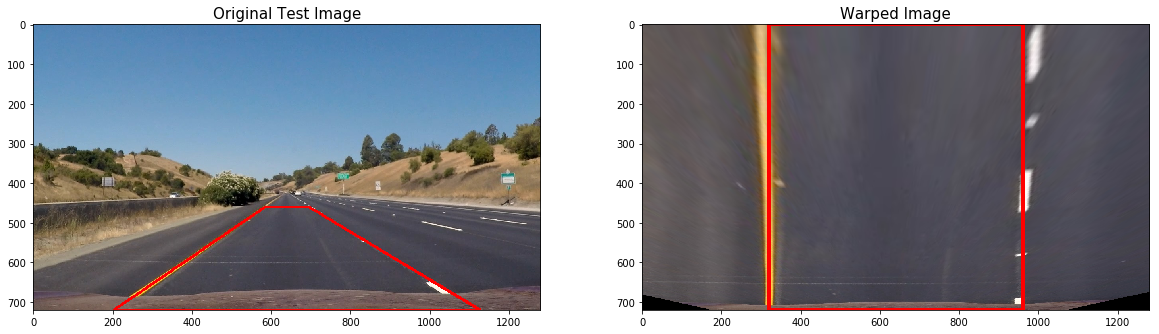

In [7]:
"""
585, 460 -> 320, 0
203, 720 -> 320, 720
1127, 720 -> 960, 720
695, 460 -> 960, 0

"""


img = cv2.imread('./examples/undistorted_with_source.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_size = (img.shape[1], img.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])



def warper(img,src,dst):    
    M = cv2.getPerspectiveTransform(src, dst)
    #Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

warped_image = warper(img, src, dst)

pts = np.array([[585, 460],[203, 720],[1127, 720],[695, 460]], np.int32)
pts = pts.reshape((-1,1,2))
copy = img.copy()
copy = cv2.polylines(copy,[pts],True,(255,0,0), thickness=5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Test Image', fontsize=15)
ax1.imshow(copy)
copy = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)
cv2.imwrite('./examples/image_with_polylines.jpg',copy)


pts = np.array([[320,0],[320, 720],[960, 720],[960,0]], np.int32)
pts = pts.reshape((-1,1,2))
warped_copy = warped_image.copy()
warped_copy = cv2.polylines(warped_copy,[pts],True,(255,0,0), thickness=10)

ax2.set_title('Warped Image', fontsize=15)
ax2.imshow(warped_copy)
warped_copy = cv2.cvtColor(warped_copy, cv2.COLOR_BGR2RGB)
cv2.imwrite('./examples/warped_image_with_polylines.jpg',warped_copy)


In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import glob
import pickle
from tracker import tracker


dist_pickle = pickle.load(open("calibration.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]



def color_threshold(img, sthresh=(0, 255), vthresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:, :, 2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

'''def color_threshold(img, sthresh=(220, 255), bthresh=(190, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= lthresh[0]) & (l_channel <= lthresh[1])] = 1
    
        
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel > bthresh[0]) & (b_channel <= bthresh[1])] = 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) | (b_binary == 1)] = 1
    return output'''
        

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output



def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0] - (level + 1) * height):int(img_ref.shape[0] - level * height),
    max(0, int(center - width)):min(int(center + width),img_ref.shape[1])] = 1
    return output

In [9]:
images = glob.glob('./test_images/test*.jpg')

for idx,fname in enumerate(images):
    #read in image
    img = cv2.imread(fname)
    img = cv2.undistort(img,mtx,dist,None,mtx)
    
    preprocessImage = np.zeros_like(img[:, :, 0])

    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100, 255), vthresh=(50, 255))
    #c_binary = color_threshold(img, sthresh=(100, 255), bthresh=(190, 255))

    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255

    img_size = (img.shape[1],img.shape[0])
    bot_width = .76 #perent of bottom trapizoid height
    mid_width = .08 #percent of middle trapizoid height
    height_pct = .62 #percent for trapizoid height
    bottom_trim = .935 #percent from top to bottom to avoid car hood

    src = np.float32([[img.shape[1] * (0.5 - mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + bot_width / 2), img.shape[0] * bottom_trim],
                      [img.shape[1] * (0.5 - bot_width / 2), img.shape[0] * bottom_trim]])
    offset = img_size[0] * 0.25
    dst = np.float32(
        [[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])

    #perform the transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)
    
    window_width = 25
    window_height = 88

    curve_centers = tracker(Mywindow_width = window_width,Mywindow_height= window_height, Mymargin = 25,My_ym = 10/720,My_xm = 4/384,Mysmooth_factor = 50)

    window_centroids = curve_centers.find_window_centroids(warped)

    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    rightx = []
    leftx = []

    for level in range(0,len(window_centroids)):
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        l_points[(l_points == 255) | ((l_mask == 1) )] = 255
        r_points[(r_points == 255) | ((r_mask == 1))] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8)
    zero_channel = np.zeros_like(template)
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8)
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)
   
    #fit the lane boundaries to the left , right center positions found
    yvals = range(0,img.shape[0])
    res_yvals = np.arange(img.shape[0] - (window_height / 2), 0, - window_height)

    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0] * yvals * yvals + left_fit[1] * yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0] * yvals * yvals + right_fit[1] * yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)

    left_lane = np.array(list(
        zip(np.concatenate((left_fitx - window_width / 2, left_fitx[::-1] + window_width / 2), axis=0),
            np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
    right_lane = np.array(list(
        zip(np.concatenate((right_fitx - window_width / 2, right_fitx[::-1] + window_width / 2), axis=0),
            np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

    middle_marker = np.array(list(
        zip(np.concatenate((left_fitx + window_width / 2, right_fitx[::-1] - window_width / 2), axis=0),
            np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road, [left_lane], color=[255, 0, 0])
    cv2.fillPoly(road, [right_lane], color=[0, 0, 255])
    cv2.fillPoly(road, [middle_marker], color=[0, 255, 0])
    cv2.fillPoly(road_bkg, [left_lane], color=[255, 255, 255])
    cv2.fillPoly(road_bkg, [right_lane], color=[255, 255, 255])
    
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)

    base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 0.7, 0.0)
    
    #result = road
    # meters per pixel in y dimension
    #ym_per_pix = curve_centers.ym_pre_pix
    ym_per_pix = 30/720
    # meters per pixel in x dimension
    #xm_per_pix = curve_centers.xm_per_pix
    xm_per_pix = 3.7/700

    curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32) * ym_per_pix, np.array(leftx, np.float32) * xm_per_pix, 2)
    curverad = ((1 + (2 * curve_fit_cr[0] * yvals[-1] * ym_per_pix + curve_fit_cr[1])**2)**1.5) / np.absolute(2*curve_fit_cr[0])
        
    # calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (camera_center - warped.shape[1] / 2) * xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # draw the text showing curvature, offset, and speed
    cv2.putText(result, 'Radius of Curvature = ' + str(round(curverad, 3)) + '(m)', (50, 50), cv2.FONT_HERSHEY_SIMPLEX,
                1, (255, 255, 255), 2)
    
    cv2.putText(result, 'Vehicle is ' + str(abs(round(center_diff, 3))) + 'm ' + side_pos + ' of center', (50, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    #result = cv2.addWeighted(warpage,1,template,0.5,0.0)
    #result =  preprocessImage
    write_name = './test_images/tracked' + str(idx) + '.jpg'
    cv2.imwrite(write_name,result)

In [ ]:
import numpy as np


def process_image(img):

    img = cv2.undistort(img, mtx, dist, None, mtx)

    preprocessImage = np.zeros_like(img[:, :, 0])

    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100, 255), vthresh=(50, 255))
    #c_binary = color_threshold(img, lthresh=(220, 255), bthresh=(190, 255))
    #c_binary = color_threshold(img, sthresh=(100, 255), bthresh=(190, 255))

    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255

    # work on the perspective transformation area

    img_size = (img.shape[1],img.shape[0])
    bot_width = .76 #perent of bottom trapizoid height
    mid_width = .08 #percent of middle trapizoid height
    height_pct = .62 #percent for trapizoid height
    bottom_trim = .935 #percent from top to bottom to avoid car hood

    src = np.float32([[img.shape[1] * (0.5 - mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + bot_width / 2), img.shape[0] * bottom_trim],
                      [img.shape[1] * (0.5 - bot_width / 2), img.shape[0] * bottom_trim]])
    offset = img_size[0] * 0.25
    dst = np.float32(
        [[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])

    #perform the transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)

    window_width = 25
    window_height = 88

    curve_centers = tracker(Mywindow_width = window_width,Mywindow_height= window_height, Mymargin = 25,My_ym = 10/720,My_xm = 4/384,Mysmooth_factor = 50)

    window_centroids = curve_centers.find_window_centroids(warped)

    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    rightx = []
    leftx = []

    for level in range(0,len(window_centroids)):
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        l_points[(l_points == 255) | ((l_mask == 1) )] = 255
        r_points[(r_points == 255) | ((r_mask == 1))] = 255

    # Draw the results
    #template = np.array(r_points+l_points,np.uint8)
    #zero_channel = np.zeros_like(template)
    #template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8)
    #warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    #result = cv2.addWeighted(warpage,1,template,0.5,0.0)


    #fit the lane boundaries to the left , right center positions found
    yvals = range(0,img.shape[0])
    res_yvals = np.arange(img.shape[0] - (window_height / 2), 0, - window_height)

    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0] * yvals * yvals + left_fit[1] * yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0] * yvals * yvals + right_fit[1] * yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)

    left_lane = np.array(list(
        zip(np.concatenate((left_fitx - window_width / 2, left_fitx[::-1] + window_width / 2), axis=0),
            np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
    right_lane = np.array(list(
        zip(np.concatenate((right_fitx - window_width / 2, right_fitx[::-1] + window_width / 2), axis=0),
            np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

    middle_marker = np.array(list(
        zip(np.concatenate((left_fitx + window_width / 2, right_fitx[::-1] - window_width / 2), axis=0),
            np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

    #print(left_fitx[700:])
    #print(right_fitx[700:])
    #diff = right_fitx - left_fitx
    #print (np.max(diff))
    #print (np.min(diff))
    #print (np.mean(diff))
    #print(np.argmax(diff))
    
    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)

    cv2.fillPoly(road, [left_lane], color=[255, 0, 0])
    cv2.fillPoly(road, [right_lane], color=[0, 0, 255])
    cv2.fillPoly(road, [middle_marker], color=[0, 255, 0])
    cv2.fillPoly(road_bkg, [left_lane], color=[255, 255, 255])
    cv2.fillPoly(road_bkg, [right_lane], color=[255, 255, 255])
    
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)

    base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 0.7, 0.0)

    # meters per pixel in y dimension
    ym_per_pix = 30/720
    # meters per pixel in x dimension
    xm_per_pix = 3.7/700

    curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32) * ym_per_pix, np.array(leftx, np.float32) * xm_per_pix, 2)
    curverad = ((1 + (2 * curve_fit_cr[0] * yvals[-1] * ym_per_pix + curve_fit_cr[1])**2)**1.5) / np.absolute(2*curve_fit_cr[0])

    # calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (camera_center - warped.shape[1] / 2) * xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # draw the text showing curvature, offset, and speed
    cv2.putText(result, 'Radius of Curvature = ' + str(round(curverad, 3)) + '(m)', (50, 50), cv2.FONT_HERSHEY_SIMPLEX,
                1, (255, 255, 255), 2)
    cv2.putText(result, 'Vehicle is ' + str(abs(round(center_diff, 3))) + 'm ' + side_pos + ' of center', (50, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return result

output_video = 'project_video_result.mp4'
Input_video = 'project_video.mp4'

#clip1 = VideoFileClip(Input_video).subclip(41,43)
#video_clip = clip1.fl_image(process_image)

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image)
video_clip.write_videofile(output_video,audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


 93%|█████████▎| 1173/1261 [02:53<00:12,  6.88it/s]